# <b>CS156 (Introduction to AI), Fall 2022</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Preet LNU
### Student ID: 014755741
### Email address: preet.lnu@sjsu.edu


##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

from zipfile import ZipFile

In [2]:
np.random.seed(42)

#### Code the solution

In [3]:
with ZipFile('/content/homework8_input_data.zip', 'r') as zipObj:
  zipObj.extractall('/content')

In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/flowers/training",
    validation_split=0.2,
    subset="training",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/flowers/training",
    validation_split=0.2,
    subset="validation",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/flowers/test",
    seed=42,
    
    labels='inferred',
    label_mode='categorical',
    
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


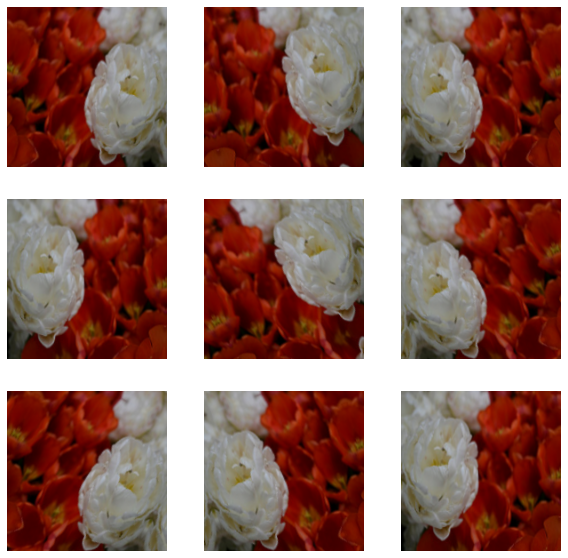

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

In [7]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
87/87 [==============================] - 818s 9s/step - loss: 1.2242 - accuracy: 0.5439 - val_loss: 1.7136 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 806s 9s/step - loss: 1.0021 - accuracy: 0.6315 - val_loss: 2.6106 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 808s 9s/step - loss: 0.8992 - accuracy: 0.6622 - val_loss: 3.0530 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 811s 9s/step - loss: 0.8134 - accuracy: 0.6915 - val_loss: 3.8752 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 809s 9s/step - loss: 0.7778 - accuracy: 0.7081 - val_loss: 3.8058 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 821s 9s/step - loss: 0.7100 - accuracy: 0.7389 - val_loss: 1.6991 - val_accuracy: 0.4559
Epoch 7/20
87/87 [==============================] - 818s 9s/step - loss: 0.6534 - accuracy: 0.7548 - val_loss: 1.3054 - val_accuracy: 0.5832
Epoch 8/20
87

In [8]:
true_labels = []
predicted_labels = []
#x = image, y = label
for x, y in test_ds:
    pred = model.predict(x)
    true_labels.append(np.where(y == 1.)[1][0])
    predicted_labels.append(np.where(pred == np.amax(pred))[1][0])

1/1 [==============================] - 0s 97ms/step


In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

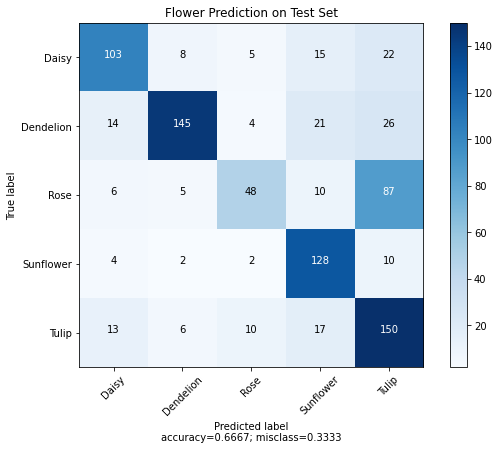

In [10]:
plot_confusion_matrix(cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy(),  
                      normalize    = False,
                      target_names = ['Daisy', 'Dendelion', 'Rose', 'Sunflower', 'Tulip'],
                      title        = "Flower Prediction on Test Set")

In [11]:
def target_translator (input_number) :
    
    if (input_number == 0) :
        return 'Daisy'
    
    elif (input_number == 1) :
        return 'Dendelion'
    
    elif (input_number == 2) :
        return 'Rose'
    
    elif (input_number == 3) :
        return 'Sunflower'
    
    elif (input_number == 4) :
        return 'Tulip'

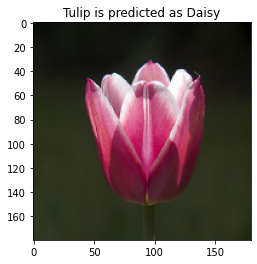

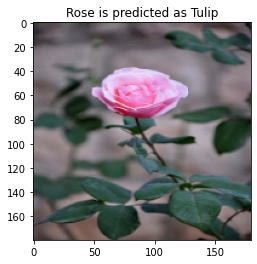

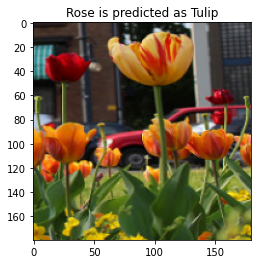

In [12]:
breaker = 0


for counter in range (100) :
    if (true_labels[counter] != predicted_labels[counter]) :
        
        plt.title(target_translator(true_labels[counter]) + ' is predicted as ' + target_translator(predicted_labels[counter]))
        
        plt.imshow(images[counter].numpy().astype("uint8"))
        
        plt.show()
        
        breaker = breaker + 1
        
    if (breaker > 2) :
        break